In [1]:
import cv2
import skimage
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def create_gaussian_filter(theta, sigma_x, sigma_y, size, filter_type='edge'):
    # Create a grid of (x, y) coordinates
    x = np.linspace(-size//2+1, size//2, size)
    y = np.linspace(-size//2+1, size//2, size)
    x, y = np.meshgrid(x, y)
    # Rotate the coordinates
    x_rot = x * np.cos(theta) + y * np.sin(theta)
    y_rot = -x * np.sin(theta) + y * np.cos(theta)
    
    # Calculate the Gaussian function f(xrot,sigmax)*f(yrot,sigmay)
    fx = np.exp(-0.5 * (x_rot**2 / sigma_x**2))/(np.sqrt(2 * np.pi) * sigma_x)
    fy = np.exp(-0.5 * (y_rot**2 / sigma_y**2))/(np.sqrt(2 * np.pi) * sigma_y)
    if filter_type == 'edge':
        # First derivative (edge)
        #x'
        dG_dx = fy*fx*(-x_rot/sigma_x**2)
        #y'
        dG_dy = fx*fy*(-y_rot/sigma_y**2)
        return dG_dx, dG_dy
    elif filter_type == 'bar':
        # Second derivative (bar)
        #x'
        d2G_dx2 = fy*fx*((x_rot-sigma_x**2)/sigma_x**4)
        #y'
        d2G_dy2 = fx*fy*((y_rot-sigma_y**2)/sigma_y**4)
        return d2G_dx2, d2G_dy2
    else:
        raise ValueError("Unknown filter type. Use 'edge' or 'bar'.")

# Example usage:
theta = 0  # No rotation
sigma_x = 1
sigma_y = 2
size = 7
filter_type = 'edge'

edge_x, edge_y = create_gaussian_filter(theta, sigma_x, sigma_y, size, filter_type)


((3, 2), (6,))


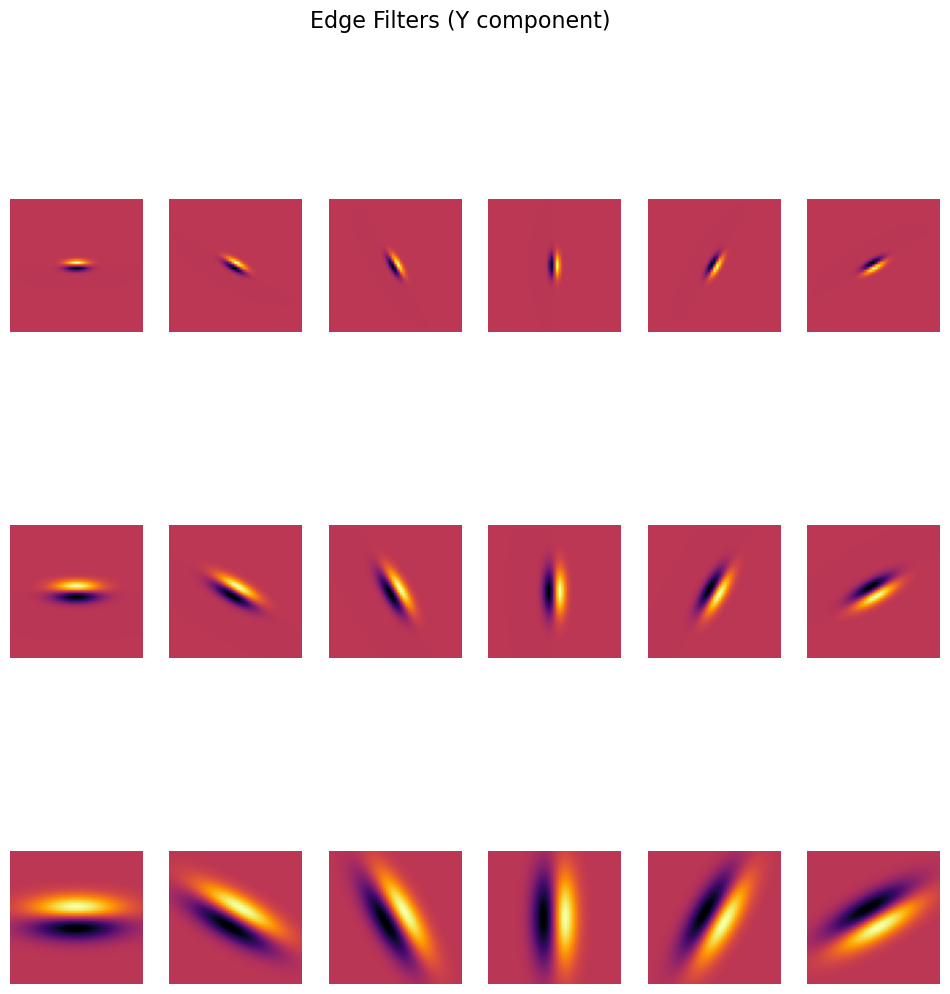

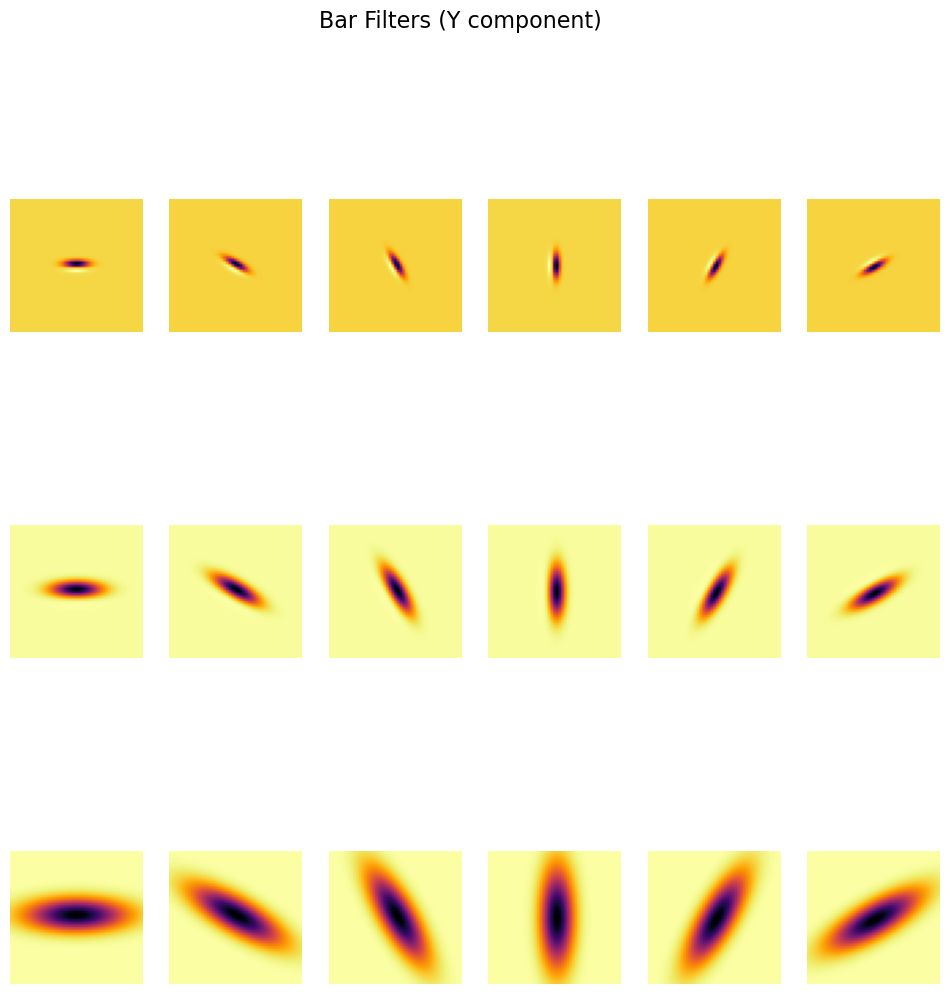

(array([[[[ 1.35106396e-139,  1.83936135e-138,  2.24080086e-137, ...,
            2.24080086e-137,  1.83936135e-138,  1.35106396e-139],
          [ 2.08023706e-129,  2.83206995e-128,  3.45016751e-127, ...,
            3.45016751e-127,  2.83206995e-128,  2.08023706e-129],
          [ 1.17607093e-119,  1.60112288e-118,  1.95056698e-117, ...,
            1.95056698e-117,  1.60112288e-118,  1.17607093e-119],
          ...,
          [-1.17607093e-119, -1.60112288e-118, -1.95056698e-117, ...,
           -1.95056698e-117, -1.60112288e-118, -1.17607093e-119],
          [-2.08023706e-129, -2.83206995e-128, -3.45016751e-127, ...,
           -3.45016751e-127, -2.83206995e-128, -2.08023706e-129],
          [-1.35106396e-139, -1.83936135e-138, -2.24080086e-137, ...,
           -2.24080086e-137, -1.83936135e-138, -1.35106396e-139]],
 
         [[ 9.51395242e-044,  2.46907920e-044,  4.57807512e-045, ...,
            4.48095851e-221,  2.44962942e-228,  9.59314145e-236],
          [ 7.23408326e-040,  

In [3]:
# Question 2
# RFS Filter bank
def construct_rfs(debug:bool = False):
    sigma_x_sigma_y = np.array([(3,1),(6,2),(12,4)])

    thetas = np.array([0,1/6*np.pi,2/6*np.pi,3/6*np.pi,4/6*np.pi,5/6*np.pi])

    print((sigma_x_sigma_y.shape,thetas.shape))
    
    size = (49,49)
    
    # rfs has 3 
    rfs_edge = np.zeros((sigma_x_sigma_y.shape[0],thetas.shape[0],size[0],size[1]))
    rfs_bar= np.zeros((sigma_x_sigma_y.shape[0],thetas.shape[0],size[0],size[1]))

    for sigma_ind in range(sigma_x_sigma_y.shape[0]):
        
        for theta_ind in range(thetas.shape[0]):
            sigma = sigma_x_sigma_y[sigma_ind]
            theta = thetas[theta_ind]
            
            # create gaussian filter returns both x' and y'
            gaussian_edge =  create_gaussian_filter(theta,sigma[0],sigma[1],size[0],'edge')
            # We only get the second element from the result to only get the differential with respect to y'
            rfs_edge[sigma_ind,theta_ind] = gaussian_edge[1]
            gaussian_bar =  create_gaussian_filter(theta,int(sigma[0]),sigma[1],size[0],'bar')
            rfs_bar[sigma_ind,theta_ind] = gaussian_bar[1]


    # rfs.append(LoGs)

    def plot_filters(filters, title, size=(49, 49)):
        rows, cols = filters.shape[:2]
        fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
        fig.suptitle(title, fontsize=16)
        
        for i in range(rows):
            for j in range(cols):
                ax = axes[i, j]
                ax.imshow(filters[i, j], cmap='inferno')
                ax.axis('off')
        
        plt.show()
        
    plot_filters(rfs_edge, title="Edge Filters (Y component)")
    plot_filters(rfs_bar, title="Bar Filters (Y component)")
    # NOTE : Rembember to add LoG and return it
    return rfs_edge,rfs_bar


construct_rfs(debug=True)
    
    

In [4]:
# Now we must make mr8 This will take in an image and then for each pixel apply every filter, but only return the max theta
from scipy.ndimage import convolve

def apply_rfs_filter_scipy(image, rfs_filters):
    max_responses = np.zeros((image.shape[0], image.shape[1], rfs_filters.shape[0]))

    for sigma_ind in range(rfs_filters.shape[0]):
        # Edge filters
        responses = []
        for theta_ind in range(rfs_filters.shape[1]):
            filter = rfs_filters[sigma_ind, theta_ind]
            response = convolve(image, filter)
            responses.append(response)
        
        max_responses[:, :, sigma_ind] = np.max(responses, axis=2)

    return max_responses